<a href="https://colab.research.google.com/github/AnhVanGiang/MO/blob/main/agg350_MO_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mathematical Optimization Assignment 1

## Preliminaries

### Install dependencies for Google Colab

In [1]:
import httpimport

with httpimport.github_repo('alessandrozocca', 'MO2022', 'helpers'):
    from helpers import installer    

    if installer.on_colab():
        installer.install_pyomo()
        installer.install_cbc()

    from helpers.assignment1 import generate_instance, solve_model, plot_solution

Installing pyomo from idaes_pse via pip ... installation successful
Installing cbc on Google Colab via zip file ... installation successful


### Import

In [2]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from IPython.display import Markdown

### Create solver

In [3]:
solver = pyo.SolverFactory("cbc")

## Problem description

A new online-only supermarket franchise, AZ, is trying to expand its market share by offering extremely efficient groceries deliveries to its customers. To do so, the R&D team need to figure out how to best create the routes for the refrigerated trucks. The strategy that AZ adopted is to have many small depots distributed across the city rather than having only a big warehouse. This means that the same truck might leave not entirely full and along the way possibly get new products from one of the small depots. Can you help the R&D team at AZ to figure out how plan these routes as efficiently as possible? You should know that AZ as a company deeply cares about sustainability. This means that instead of myopically minimizing the travelled distance of its trucks, they want to account for the fuel consumption of the trucks which also depends on their load. In the 2nd part of the problem, can you help the R&D team at AZ to figure out how to make the truck routes efficient and green at the same time?


To summarize, the problem to be solved is the following:
- Find a single route visiting all nodes, given a fixed start and finish location.
- Each node has a certain demand of a single product to be fulfilled.
    - Delivery:   Nodes having a negative demand.
    - Pickup:     Nodes having a positive demand.
    - Service:    Nodes having a zero demand.
- Each node is only available to be visited after a given time.

A problem instance is defined by a list of nodes. Each node has a specific demand, earliest arrival time and xy-coordinate. Instances of varying sizes can be randomly created, using the provided function `generate_instance`. Assume that the node on the first line is the fixed starting location and the node on the last line is the fixed finish location. For example:

In [4]:
instance = generate_instance(n_nodes=5, seed=0)
instance

,demand,earliest_arrival,coord
1,0,0,"(47, 50)"
2,-10,16,"(55, 53)"
3,9,25,"(25, 56)"
4,4,0,"(52, 67)"
5,-3,0,"(39, 76)"


You can assume the following functions to hold:

\begin{align}
\operatorname{travel\_distance}(a,\ b) &= ||a - b||_2 &\text{(in kilometers, given cartesian coordinates $a$ and $b$)} \\
\operatorname{travel\_time}(distance) &= 1.2 \cdot distance + 1 &\text{(in minutes, given a travel $distance$ in kilometers)}\\
\operatorname{fuel\_usage}(time,\ load) &= time \cdot \Big( 0.02 \cdot load + 0.3 \Big) &\text{(in liters, given a travel $time$ in minutes and $load$ in $\times 10^3$ kg)}
\end{align}

Their implementations are given below.

In [5]:
def compute_travel_distance(a, b):
    """ Compute the (Euclidean) distance in kilometers,
        between two given coordinates [a] and [b] """
    return np.linalg.norm(np.subtract(a, b))

def compute_travel_time(distance):
    """ Compute the travel time in minutes,
        given a certain [distance] in kilometers"""
    return 1.2 * distance + 1

def compute_fuel_usage(time, load):
    """ Compute the fuel usage in liters,
        given a certain traveling [time] in minutes
        and a certain [load] in x10^3 kg"""
    return time * (0.02 * load + 0.3)

def create_travel_times_matrix(instance):
    """ Create a dataframe containing all travel times in an [instance] represented in matrix form """
    return pd.DataFrame({i: {j: compute_travel_time(compute_travel_distance(instance['coord'][i], instance['coord'][j])) for j in instance.index} for i in instance.index})

## MILP Formulation

Let:

- $N$ be the set of all nodes to be visited by the vehicle.
- $s$ and $t$ respectively be the fixed source and target nodes.
- $d$ be an array where each element $d_i$ denotes the demand at node $i$.
- $r$ be an array where each element $r_i$ denotes the earliest allowed arrival time at node $i$.
- $T$ be a matrix where each element $T_{i, j}$ denotes the required travel time from node $i$ to $j$.

Then this problem can be formulated as a MILP:

>\begin{array}{lrclll}
 \min & \sum\limits_{i \in N} \sum\limits_{j \in N} {x_{i, j}} \cdot T_{i, j} &&&& \scriptstyle\text{(Minimize the total travel time over all used edges)} \\
 \mbox{s.t.} & \sum\limits_{j \in N \setminus \{i\}} x_{i, j} & = & 1 & \forall i \in N \setminus \{t\} & \scriptstyle\text{(Every non-target node should have exactly one outgoing edge)}\\
 & \sum\limits_{i \in N \setminus \{j\}} x_{i, j} & = & 1 & \forall j \in N \setminus \{s\} & \scriptstyle\text{(Every non-starting node should have exactly one incoming edge)}\\\\ & \tau_i + T_{i, j} & \leq & \tau_j + (1 - x_{i, j})\cdot M_{arrival\_time} & \forall (i, j) \in N \times N & \scriptstyle\text{(You do not arrive at a node before the arrival time at the previous node plus the travel time from there)}\\
 & r_i & \leq & \tau_i & \forall i \in N & \scriptstyle\text{(You should never arrive before the earliest pickup/delivery time at a node)}\\\\
 & \ell_s & = & d_s && \scriptstyle\text{(⋆)} \\
 & \ell_i + d_j & \leq& \ell_j + (1 - x_{i, j})\cdot M_{load} & \forall (i, j) \in N \times N & \scriptstyle\text{(⋆)}\\
 & \ell_i + d_j & \geq& \ell_j - (1 - x_{i, j})\cdot M_{load} & \forall (i, j) \in N \times N & \scriptstyle\text{(⋆)}\\\\
 & \tau_i & \geq & 0 & \forall i \in N & \scriptstyle\text{(Variable representing the time when arriving at the corresponding node)}\\
 & \ell_i & \geq & 0 & \forall i \in N & \scriptstyle\text{(⋆)}\\
 & x_{i, j} & \in & \mathbb{B} & \forall (i, j) \in N \times N & \scriptstyle\text{(Binary variable with value true iff the corresponding edge is part of the chosen route)} \\
\end{array}

For which a pyomo implementation is given below.

In [9]:
def make_base_model(demands, earliest_arrivals, travel_times):
    model = pyo.ConcreteModel()

    # Parameters
    model.n_nodes = len(demands)

    # Big-M values
    model.M_load = demands.max() * model.n_nodes + 1
    model.M_arrival_time = travel_times.max().max() * model.n_nodes + 1

    # Sets
    model.nodes = pyo.RangeSet(model.n_nodes)

    # Variables
    model.arc = pyo.Var(model.nodes, model.nodes, domain=pyo.Binary, initialize=0)
    model.node_load = pyo.Var(model.nodes, domain=pyo.NonNegativeReals, initialize=0)
    
    model.node_arrival = pyo.Var(model.nodes, domain=pyo.NonNegativeReals, initialize=0)

    # Expressions 
    @model.Expression()
    def total_travel_time(m):
        return sum(m.arc[i, j] * travel_times[i][j] for i in m.nodes for j in m.nodes)

    # Objectives
    # (Note that we do not define any objective here yet, in order to be
    #  able to choose between different expressions to act as objective later)

    # Constraints
    @model.Constraint(model.nodes - {model.n_nodes}) # All nodes except target node
    def one_outgoing(m, i):
        return sum(m.arc[i, j] for j in m.nodes if i != j) == 1

    @model.Constraint(model.nodes - {1}) # All nodes except source node
    def one_incoming(m, j):
        return sum(m.arc[i, j] for i in m.nodes if i != j) == 1

    @model.Constraint(model.nodes, model.nodes)
    def node_arrivals(m, i, j):
        return m.node_arrival[i] + travel_times[i][j] <= m.node_arrival[j] + m.M_arrival_time * (1 - m.arc[i, j])

    @model.Constraint(model.nodes)
    def time_windows_open(m, i):
        return earliest_arrivals[i] <= m.node_arrival[i]

    @model.Constraint()
    def start_load(m):
        return m.node_load[1] == demands[1]

    @model.Constraint(model.nodes, model.nodes)
    def node_loads_upper(m, i, j):
        return m.node_load[i] + demands[j] <= m.node_load[j] + m.M_load * (1 - m.arc[i, j])
    
    @model.Constraint(model.nodes, model.nodes)
    def node_loads_lower(m, i, j):
        return m.node_load[i] + demands[j] >= m.node_load[j] - m.M_load * (1 - m.arc[i, j])

    return model

You can use all provided helper functions, including:
- `generate_instance(n_nodes, seed)`
- `solve_model(solver, model)`
- `plot_solution(coords, model)`

Run `?<function_name>` to inspect a function's signature and documentation or inspect the full implementations [here](https://raw.githubusercontent.com/alessandrozocca/MO2022/main/helpers/assignment1.py). For example:

## Example instance

Optimal solution found in 0.44s
Total travel time: 117.15


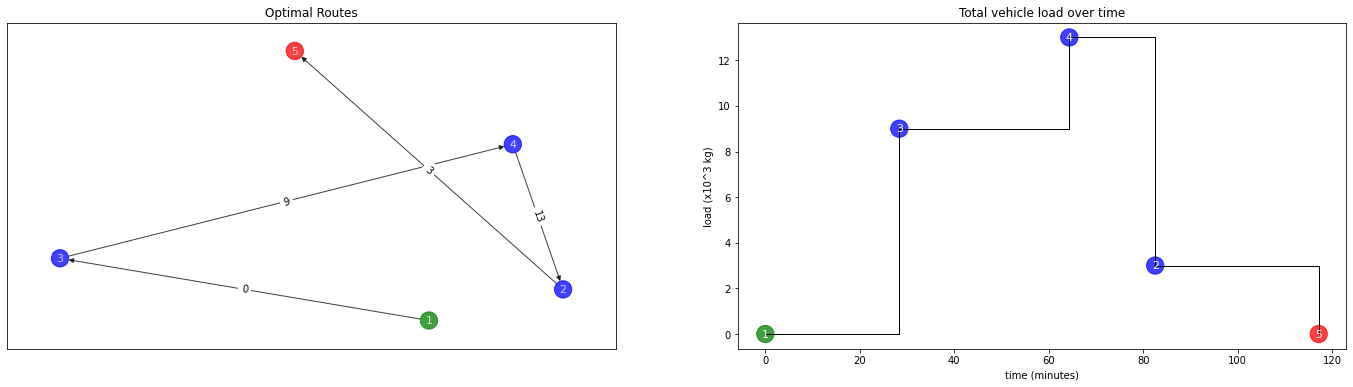

In [10]:
travel_times = create_travel_times_matrix(instance)

display(Markdown("## Example instance"))
model = make_base_model(instance["demand"], instance["earliest_arrival"], travel_times)
# Set model objective here, using an earlier defined expression
model.obj = pyo.Objective(expr=model.total_travel_time)
solve_model(solver, model)
print("Total travel time: %.2f" % model.total_travel_time())

plot_solution(instance["coord"], model)

## Questions

Your task is to answer the following questions regarding this assignment:
- 1a) [10pt] Some lines in the provided MILP formulation have not been explained. Give a short explanation of those lines, marked with a (⋆). Explain what the variables stand for, what the constraints aim to achieve and how they succeed in doing this (Including the role of the big-M)?
- 1b) [10pt] There are two big-M values used in the provided model's constraints, implemented with some value. Explain how you could derive better bounds for both values. 
- 2) [20pt] Imagine a version of this problem, that does not have the `earliest arrival` restriction on the arrival times. Explain why we cannot just remove the $\tau$ variables and all constraints in which they occur. Hint: Test what would happen in the instance with 10 nodes and seed 4.
- 3a) [10pt] The provided model aims to minimize the total travel time of a route. However, we also know how to compute the total fuel consumption, as a function of travel times and load at each edge. Explain how you could change to model to explicitly minimize the total fuel usage instead of the total travel time. Make sure to fully **mathematically** write out the additions/changes you make to the model.
- 3b) [10pt] Implement you solution to 3a). You should be able to do this without changing or repeating code in the provided function `make_base_model`. Rather build your model on top of the model this function returns. 
- 3c) [5pt] Solve both the provided model as well as your new model on instances of `size=10` with `seed=0...5` (so six instances in total) and plot the solutions. With your new model, for some instances it could take up to 5 minutes to find the optimal solution. The instances are generated in such a way that the first node has always nonnegative demand, i.e., it is always a pickup node.
- 3d) [10pt] Compare the results between both models. Comment on the differences and explain if they are as expected. Did we manage to save fuel? How was this achieved?
- 4a) [10pt] How could you adjust the provided model (with time objective) to work for $k \geq 2$ vehicles that both serve a part of the nodes? Assume each node cannot be visited by more than one truck. Make use of fixed starting locations $s_1, \dots, s_k$ as well as fixed finish locations $t_1, \dots, t_k$. It does not matter which vehicle ends up in which location, i.e., for instance both routes ($s_1, \dots, t_1$) or ($s_1, \dots, t_2$) would be fine. Write down how to adjust the model **mathematically**.
- 4b) [5pt] Implement the solution for question 4a) for $k=2$. You can use `generate_instance(n_nodes=10, seed=4, n_vehicles=2)` and `generate_instance(n_nodes=20, seed=4, n_vehicles=2)` to generate a example instance and `plot_solution(coords, model)` to check your model. Assume the first 2 nodes in the instance to be the source nodes and the last 2 nodes to be the target nodes. The instances are generated in such a way that the first 2 nodes have always nonnegative demand, i.e., they are always pickup nodes.

## Solutions

### 1a)

*   $\ell_i$: load of the truck at node $i$.
*   $d_i$: demand at node $i$. 
*   $\ell_s = d_s$: load of starting node = demand of starting node because the truck starts at $s$.
*   $\ell_i + d_j \leq \ell_j + (1 - x_{i, j})\cdot M_{load}$ and $\ell_i + d_j \geq \ell_j - (1 - x_{i, j})\cdot M_{load}$: if $(i,j)$ is the chosen route then $x_{i,j} = 1$ then $\ell_i + d_j = \ell_j$, i.e the load when the truck arrives at $i$ and carry the demand at $j$ must have the same load when leaving $j$. On the other hand, if $(i,j)$ is not the chosen route then $\ell_j - M_{load} \leq \ell_i + d_j \leq \ell_j + M_{load}$ making the constraint effectively redundant because of the magnitude of $M_{load}$, which is chosen to be so large that $\ell_i + d_j$ will always satisfy the constraint. 
*   $\ell_i \geq 1$: the load must always be non-negative otherwise it would not make sense. 





### 1b)

For $M_{load}$, let $M_{load}$ be the sum of the positive demand for each node then it follows that $\ell_i - \ell_j + d_i \leq M_{load}$ for all $i,j$ because $M_{load}$ already contains the information of $\ell_i, d_i$ for all $i$. For example, in the worst case, if the paths from the source to $i$ and $j$ have no common edge then the sum of the loads at $i$ and $j$ will be smaller than $M_{load}$ since $M_{load}$ represents the total amount of demand. On the other hand, if their path shares any common edge then the expression $\ell_i - \ell_j$ will cancel the common ones and revert to the previous case. Note that this new $M_{load}$ is smaller than the original one. 

We can apply the same logic to $M_{arrival\_time}$ and let it be $\sum_{i}\sum_{j} T_{i,j}$ which is smaller than the original quantity. 

### 2)

In [11]:
def make_ex2_model(demands, travel_times):
    model = pyo.ConcreteModel()

    # Parameters
    model.n_nodes = len(demands)

    # Big-M values
    model.M_load = demands.max() * model.n_nodes + 1
    model.M_arrival_time = travel_times.max().max() * model.n_nodes + 1

    # Sets
    model.nodes = pyo.RangeSet(model.n_nodes)

    # Variables
    model.arc = pyo.Var(model.nodes, model.nodes, domain=pyo.Binary, initialize=0)
    model.node_load = pyo.Var(model.nodes, domain=pyo.NonNegativeReals, initialize=0)
    
    #model.node_arrival = pyo.Var(model.nodes, domain=pyo.NonNegativeReals, initialize=0)

    # Expressions 
    @model.Expression()
    def total_travel_time(m):
        return sum(m.arc[i, j] * travel_times[i][j] for i in m.nodes for j in m.nodes)

    # Objectives
    # (Note that we do not define any objective here yet, in order to be
    #  able to choose between different expressions to act as objective later)

    # Constraints
    @model.Constraint(model.nodes - {model.n_nodes}) # All nodes except target node
    def one_outgoing(m, i):
        return sum(m.arc[i, j] for j in m.nodes if i != j) == 1

    @model.Constraint(model.nodes - {1}) # All nodes except source node
    def one_incoming(m, j):
        return sum(m.arc[i, j] for i in m.nodes if i != j) == 1

    # @model.Constraint(model.nodes, model.nodes)
    # def node_arrivals(m, i, j):
    #     return m.node_arrival[i] + travel_times[i][j] <= m.node_arrival[j] + m.M_arrival_time * (1 - m.arc[i, j])

    # @model.Constraint(model.nodes)
    # def time_windows_open(m, i):
    #     return earliest_arrivals[i] <= m.node_arrival[i]

    @model.Constraint()
    def start_load(m):
        return m.node_load[1] == demands[1]

    @model.Constraint(model.nodes, model.nodes)
    def node_loads_upper(m, i, j):
        return m.node_load[i] + demands[j] <= m.node_load[j] + m.M_load * (1 - m.arc[i, j])
    
    @model.Constraint(model.nodes, model.nodes)
    def node_loads_lower(m, i, j):
        return m.node_load[i] + demands[j] >= m.node_load[j] - m.M_load * (1 - m.arc[i, j])

    return model

## Instance of Ex 2 (with tau)

Optimal solution found in 8.26s
Total travel time: 220.17


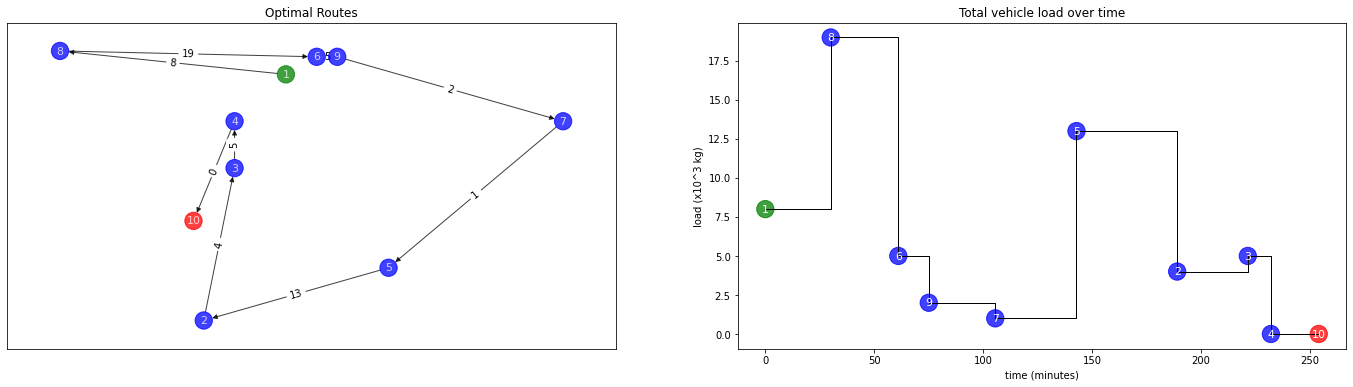

In [12]:
instance2_1 = generate_instance(n_nodes=10, seed=4)
travel_times2_1 = create_travel_times_matrix(instance2_1)

display(Markdown("## Instance of Ex 2 (with tau)"))
model2_1 = make_base_model(instance2_1["demand"], instance2_1["earliest_arrival"], travel_times2_1)
# Set model objective here, using an earlier defined expression
model2_1.obj = pyo.Objective(expr=model2_1.total_travel_time)
solve_model(solver, model2_1)
print("Total travel time: %.2f" % model2_1.total_travel_time())

plot_solution(instance2_1["coord"], model2_1)

## Instance of Ex 2 (without tau)

Optimal solution found in 0.46s
Total travel time: 201.09


AttributeError: ignored

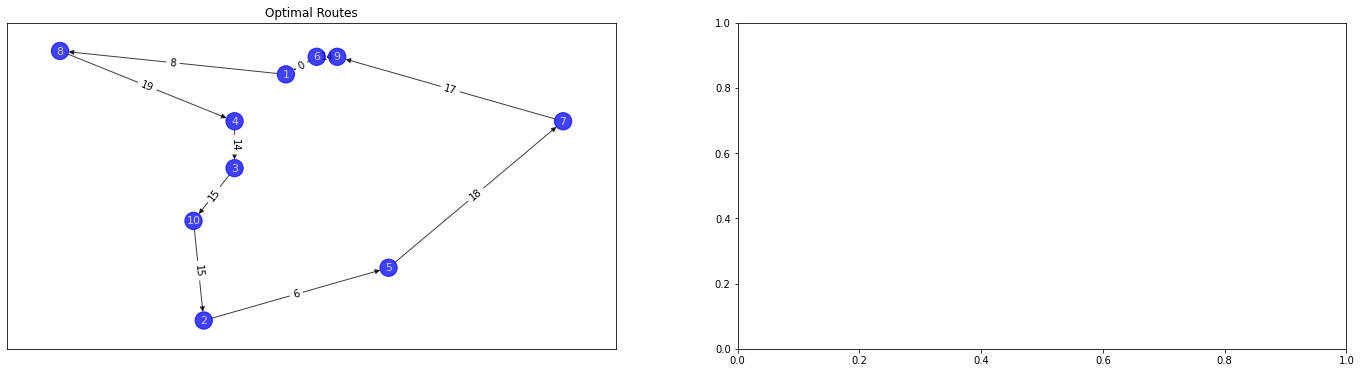

In [13]:
instance2 = generate_instance(n_nodes=10, seed=4)
travel_times2 = create_travel_times_matrix(instance2)

display(Markdown("## Instance of Ex 2 (without tau)"))
model2 = make_ex2_model(instance2["demand"], travel_times2)
# Set model objective here, using an earlier defined expression
model2.obj = pyo.Objective(expr=model2.total_travel_time)
solve_model(solver, model2)
print("Total travel time: %.2f" % model2.total_travel_time())

plot_solution(instance2["coord"], model2)

It seems that, by removing $\tau$ and all the constraints with it, the network also remove where are the source and target of the network. 

### 3a)

The new model is 

\begin{array}{lrclll}
 \min & \sum\limits_{i \in N} \sum\limits_{j \in N} {x_{i, j}} \cdot \text{fuel_usage}(T_{i,j}, \ell_i) &&&& \scriptstyle\text{(Minimize the total fuel usage over all used edges)} \\
 \mbox{s.t.} & \sum\limits_{j \in N \setminus \{i\}} x_{i, j} & = & 1 & \forall i \in N \setminus \{t\} & \scriptstyle\text{(Every non-target node should have exactly one outgoing edge)}\\
 & \sum\limits_{i \in N \setminus \{j\}} x_{i, j} & = & 1 & \forall j \in N \setminus \{s\} & \scriptstyle\text{(Every non-starting node should have exactly one incoming edge)}\\\\ & \tau_i + T_{i, j} & \leq & \tau_j + (1 - x_{i, j})\cdot M_{arrival\_time} & \forall (i, j) \in N \times N & \scriptstyle\text{(You do not arrive at a node before the arrival time at the previous node plus the travel time from there)}\\
 & r_i & \leq & \tau_i & \forall i \in N & \scriptstyle\text{(You should never arrive before the earliest pickup/delivery time at a node)}\\\\
 & \ell_s & = & d_s && \scriptstyle\text{(⋆)} \\
 & \ell_i + d_j & \leq& \ell_j + (1 - x_{i, j})\cdot M_{load} & \forall (i, j) \in N \times N & \scriptstyle\text{(⋆)}\\
 & \ell_i + d_j & \geq& \ell_j - (1 - x_{i, j})\cdot M_{load} & \forall (i, j) \in N \times N & \scriptstyle\text{(⋆)}\\\\
 & \tau_i & \geq & 0 & \forall i \in N & \scriptstyle\text{(Variable representing the time when arriving at the corresponding node)}\\
 & \ell_i & \geq & 0 & \forall i \in N & \scriptstyle\text{(⋆)}\\
 & x_{i, j} & \in & \mathbb{B} & \forall (i, j) \in N \times N & \scriptstyle\text{(Binary variable with value true iff the corresponding edge is part of the chosen route)} \\
\end{array}

To change the model to minimize the fuel usage, we only have to change the objective function since all the other constraints still hold. The changes are reflected above. 

### 3b)

### 3c)

### 3d)

### 4a)

### 4b)